# Amazon Bedrock Batch Inference

## 情報
### 公開情報
- 開発者ドキュメント: https://docs.aws.amazon.com/bedrock/latest/userguide/batch-inference.html
- Quota: https://docs.aws.amazon.com/bedrock/latest/userguide/quotas.html#quotas-batch
- コードサンプル: https://docs.aws.amazon.com/bedrock/latest/userguide/batch-inference-example.html

### 2024.1.25
- Public Preview
- 利用方法
    - REST API: あると思うが面倒
    - CLI: 無さそう
    - SDK: プレビューのがある
        - PythonとJavaのみ
        - https://d2eo22ngex1n9g.cloudfront.net/Documentation/SDK/bedrock-python-sdk-reinvent.zip
    - コンソール: 無さそう

## 背景
- Bedrockのbatch推論のquotaがon demandと関係ない（だからquotaに引っ掛からなくてうれしい）と言う説
- text to image (SDXL or Titan or Both)で500枚くらいバッチ推論ジョブを発行してどんな風に実行が完了するか（もしくは完了しないか）を見てみる
- On demandのquotaより明らかに早かったら嬉しい


## 検証条件
- 推論方式: バッチ
- 生成: テキストから画像
- モデル: amazon.titan-image-generator-v1 & stability.stable-diffusion-xl-v1

In [1]:
prompt = "A dog running at a park."

## 単発推論

まずは単発を確認

サンプルコード: https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-titan-image.html#model-parameters-titan-image-code-examples

In [ ]:
import base64
import io
import json
import logging
import boto3
from PIL import Image
from botocore.exceptions import ClientError


logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

class ImageError(Exception):
    "Custom exception for errors returned by Titan Image Generator G1"
    def __init__(self, message):
        self.message = message


def generate_image(model_id, body):
    """
    Generate an image using Titan Image Generator G1 model on demand.
    Args:
        model_id (str): The model ID to use.
        body (str) : The request body to use.
    Returns:
        image_bytes (bytes): The image generated by the model.
    """

    logger.info("Generating image with Titan Image Generator G1 model %s", model_id)

    bedrock = boto3.client(service_name='bedrock-runtime')
    accept = "application/json"
    content_type = "application/json"

    response = bedrock.invoke_model(
        body = body,
        modelId = model_id,
        accept = accept,
        contentType = content_type
    )
    response_body = json.loads(response.get("body").read())

    base64_image = response_body.get("images")[0]
    base64_bytes = base64_image.encode('ascii')
    image_bytes = base64.b64decode(base64_bytes)

    finish_reason = response_body.get("error")

    if finish_reason is not None:
        raise ImageError(f"Image generation error. Error is {finish_reason}")

    logger.info("Successfully generated image with Titan Image Generator G1 model %s", model_id)

    return image_bytes


def main():
    """
    Entrypoint for Titan Image Generator G1 example.
    """

    logging.basicConfig(
        level = logging.INFO,
        format = "%(levelname)s: %(message)s"
    )

    model_id = 'amazon.titan-image-generator-v1'

    body = json.dumps({
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": prompt
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "quality": "standard",
            "height": 1024,
            "width": 1024,
            "cfgScale": 8.0,
            "seed": 0
        }
    })

    try:
        image_bytes = generate_image(
            model_id = model_id,
            body = body
        )
        image = Image.open(io.BytesIO(image_bytes))
        image.show()

    except ClientError as err:
        message = err.response["Error"]["Message"]
        logger.error("A client error occurred: %s", message)
        print("A client error occured: " + format(message))
    except ImageError as err:
        logger.error(err.message)
        print(err.message)

    else:
        print(f"Finished generating image with Titan Image Generator G1 model {model_id}.")


if __name__ == "__main__":
    main()

## 検証

### 環境準備

In [ ]:
SDK = "sdk"
ZIP = f"{SDK}.zip"
! wget --no-check-certificate -O $ZIP https://d2eo22ngex1n9g.cloudfront.net/Documentation/SDK/bedrock-python-sdk-reinvent.zip

In [ ]:
! unzip -n -d $SDK $ZIP

下記より、以下を参照: https://docs.aws.amazon.com/bedrock/latest/userguide/batch-inference-example.html

In [ ]:
! find $SDK -type f -name boto*.whl

In [ ]:
! pip install $SDK/botocore-1.32.4-py3-none-any.whl
! pip install $SDK/boto3-1.29.4-py3-none-any.whl

In [ ]:
! aws --version

### 入力データフォーマット
参考: https://docs.aws.amazon.com/bedrock/latest/userguide/batch-inference-data.html

以下、サンプルの入力JSON

入力JSON Linesフォーマット
```JSON
{
    "recordId": "12 character alphanumeric string",
    "modelInput": {JSON body}
}
...
{
    "recordId": "12 character alphanumeric string",
    "modelInput": {JSON body}
}
```

Titanの場合の推論入力JSON: https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-titan-text.html#model-parameters-titan-request-body

```JSON
{
    "inputText": string,
    "textGenerationConfig": { // オプション
        "temperature": float,  
        "topP": float,
        "maxTokenCount": int,
        "stopSequences": [string]
    }
}
```

Tiatanの場合のバッチ推論入力JSON Lines
```JSON
{
    "modelInput": {
        "inputText": string,
        "textGenerationConfig": { // オプション
            "temperature": float,  
            "topP": float,
            "maxTokenCount": int,
            "stopSequences": [string]
        }
    }
}
...
{
    "modelInput": {
        "inputText": string,
        "textGenerationConfig": { // オプション
            "temperature": float,  
            "topP": float,
            "maxTokenCount": int,
            "stopSequences": [string]
        }
    }
}
```

### 条件設定

In [2]:
model_id:str = "amazon.titan-image-generator-v1"
# model_id:str = "stability.stable-diffusion-xl-v1"

number_of_images:int = 4
image_generation_config:dict = {
    "numberOfImages": 1,
    "quality": "standard",
    "height": 1024,
    "width": 1024,
    "cfgScale": 8.0,
    "seed": 0
}

file_name:str = "input"

### 環境設定の読み込み

In [3]:
from yaml import safe_load
with open("config.yaml") as config_file:
    config = safe_load(config_file)

role = config.get("role")
bucket_name = config.get("bucket_name")

### バッチ用入力データ出力

In [4]:
prompts = [prompt for _ in range(number_of_images)]

NameError: name 'prompt' is not defined

In [5]:
import json

requests = list()
for i, prompt in enumerate(prompts):
    body = {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": prompt
        },
        # "imageGenerationConfig": image_generation_config
    }
    record = {"recordId": str(i).zfill(12), "modelInput": body}
    requests.append(json.dumps(record))
else:
    jsonl = "\n".join(requests)
    
jsonl

NameError: name 'prompts' is not defined

In [6]:
from boto3 import resource
s3 = resource('s3')
bucket = s3.Bucket(bucket_name)
dir = "Bedrock/Batch-Inference"
jsonl_key = f"{dir}/input/{file_name}.jsonl"
jsonl_obj = bucket.Object(key=jsonl_key)
jsonl_obj.put(Body=jsonl)

NameError: name 'jsonl' is not defined

In [ ]:
! aws s3 cp s3://$bucket_name/$jsonl_key -

{"recordId": "000000000000", "modelInput": {"taskType": "TEXT_IMAGE", "textToImageParams": {"text": "A dog running at a park."}, "imageGenerationConfig": {"numberOfImages": 1, "quality": "standard", "height": 1024, "width": 1024, "cfgScale": 8.0, "seed": 0}}}
{"recordId": "000000000001", "modelInput": {"taskType": "TEXT_IMAGE", "textToImageParams": {"text": "A dog running at a park."}, "imageGenerationConfig": {"numberOfImages": 1, "quality": "standard", "height": 1024, "width": 1024, "cfgScale": 8.0, "seed": 0}}}
{"recordId": "000000000002", "modelInput": {"taskType": "TEXT_IMAGE", "textToImageParams": {"text": "A dog running at a park."}, "imageGenerationConfig": {"numberOfImages": 1, "quality": "standard", "height": 1024, "width": 1024, "cfgScale": 8.0, "seed": 0}}}
{"recordId": "000000000003", "modelInput": {"taskType": "TEXT_IMAGE", "textToImageParams": {"text": "A dog running at a park."}, "imageGenerationConfig": {"numberOfImages": 1, "quality": "standard", "height": 1024, "widt

### 推論

In [7]:
from boto3 import client
bedrock = client(service_name="bedrock")

In [8]:
inputDataConfig = ({
    "s3InputDataConfig": {
        "s3Uri": f"s3://{bucket_name}/{jsonl_key}"
    }
})

output_dir:str = f"s3://{bucket_name}/{dir}/output/"
outputDataConfig=({
    "s3OutputDataConfig": {
        "s3Uri": output_dir
    }
})

from utils import get_formatted_time
job_name:str = f"{model_id}-{get_formatted_time()}"
job_name

'amazon.titan-image-generator-v1-20240129-114428'

In [9]:
response = bedrock.create_model_invocation_job(
    roleArn = role,
    modelId = model_id,
    jobName = job_name,
    inputDataConfig = inputDataConfig,
    outputDataConfig = outputDataConfig
)
response

{'ResponseMetadata': {'RequestId': '8f6be78b-164f-47f6-a0e3-d18e91285377',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 29 Jan 2024 02:44:28 GMT',
   'content-type': 'application/json',
   'content-length': '85',
   'connection': 'keep-alive',
   'x-amzn-requestid': '8f6be78b-164f-47f6-a0e3-d18e91285377'},
  'RetryAttempts': 0},
 'jobArn': 'arn:aws:bedrock:us-east-1:624045005200:model-invocation-job/zxvq2eo4vl8d'}

In [10]:
job_arn = response.get("jobArn")
job_id = job_arn.split("/")[-1].strip()
job_id

'zxvq2eo4vl8d'

ジョブの状態はこちら: https://docs.aws.amazon.com/bedrock/latest/userguide/batch-inference-list.html

In [11]:
from time import sleep
job_status:str = "Submitted"

while job_status in ("Submitted", "InProgress"):
    sleep(10)
    job:dict = bedrock.get_model_invocation_job(jobIdentifier=job_arn)
    job_status:str = job.get("status")
    print(job_status)

bedrock.get_model_invocation_job(jobIdentifier=job_arn).get("message")
! aws s3 cp $output_dir$job_id/manifest.json.out -

Submitted
Submitted
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress


In [ ]:
# jobs = bedrock.list_model_invocation_jobs().get("invocationJobSummaries")
# for job in jobs: print(job.get("status"))

以下のファイル内容表示はたった数枚でもエディタが重くなるデータサイズなので注意

In [ ]:
# ! aws s3 cp $output_dir$job_id/input.jsonl.out -

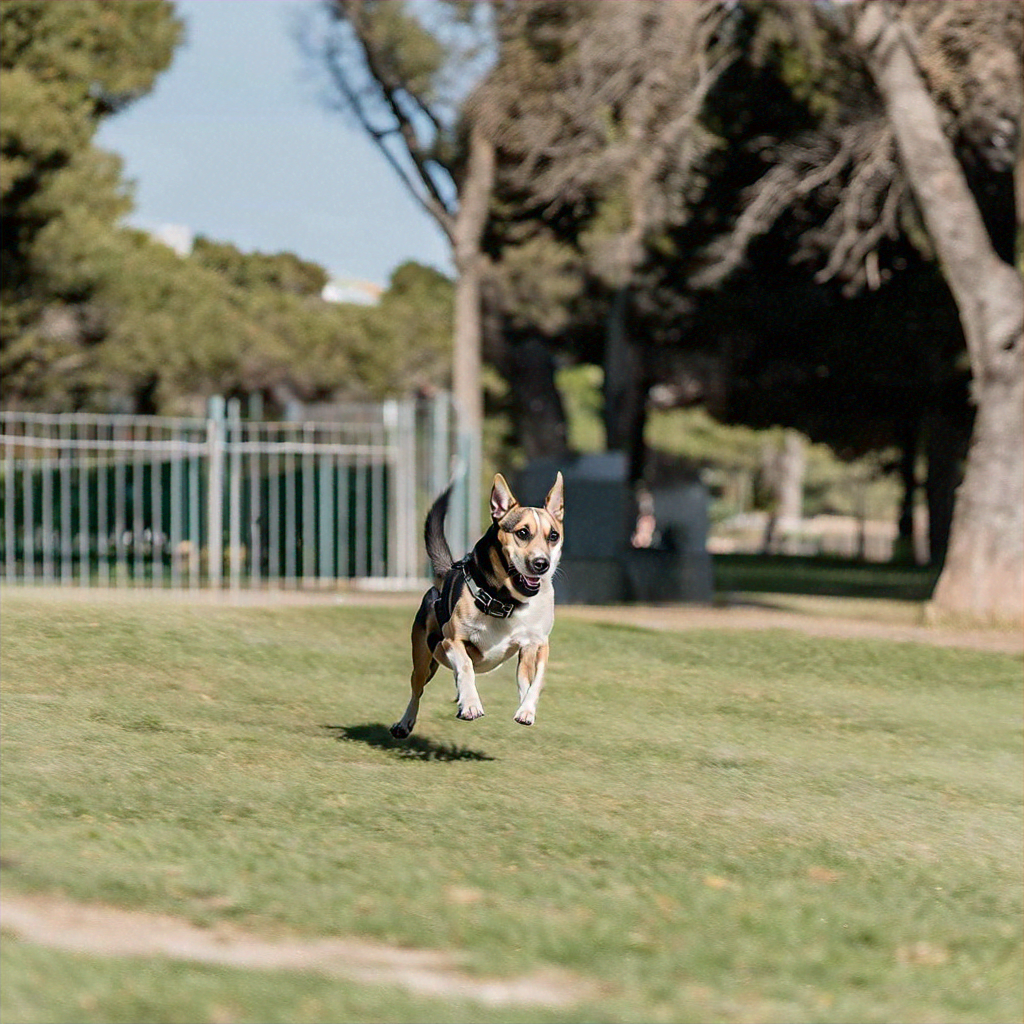

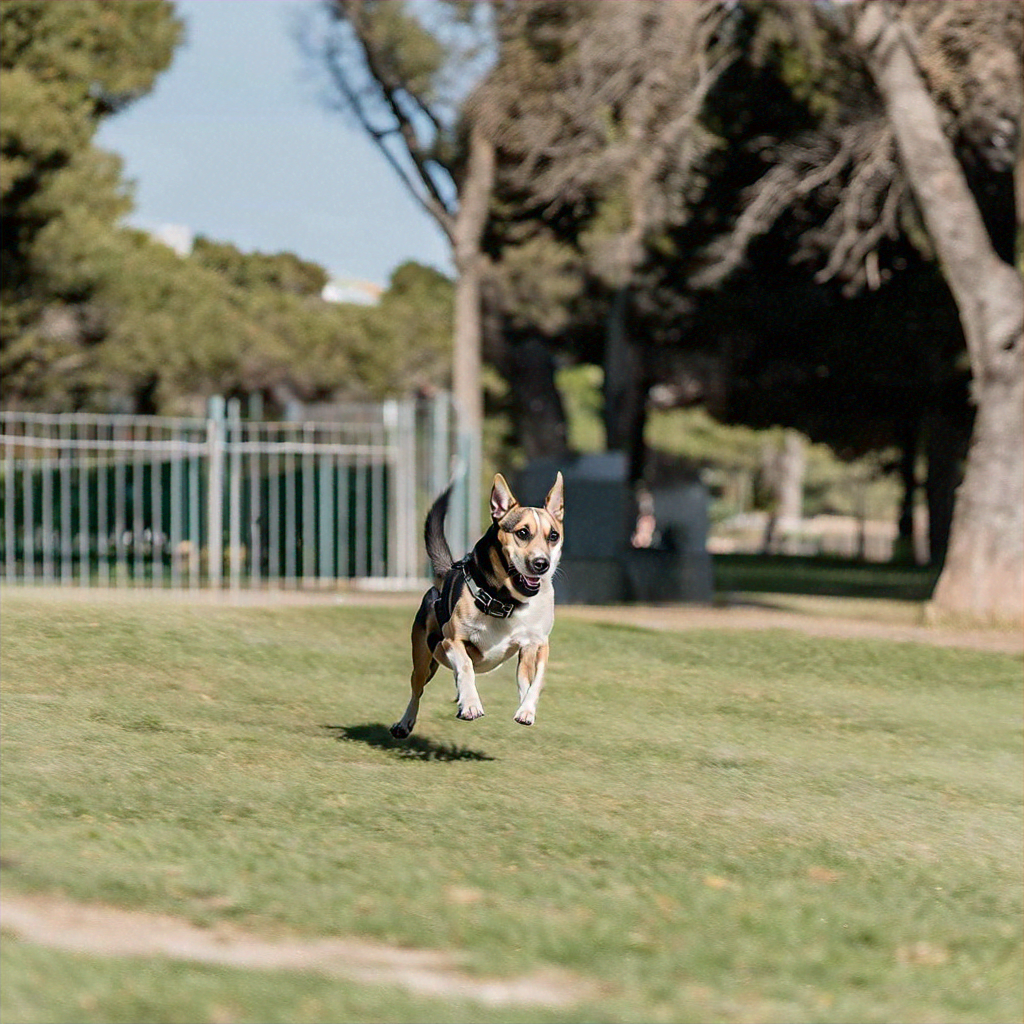

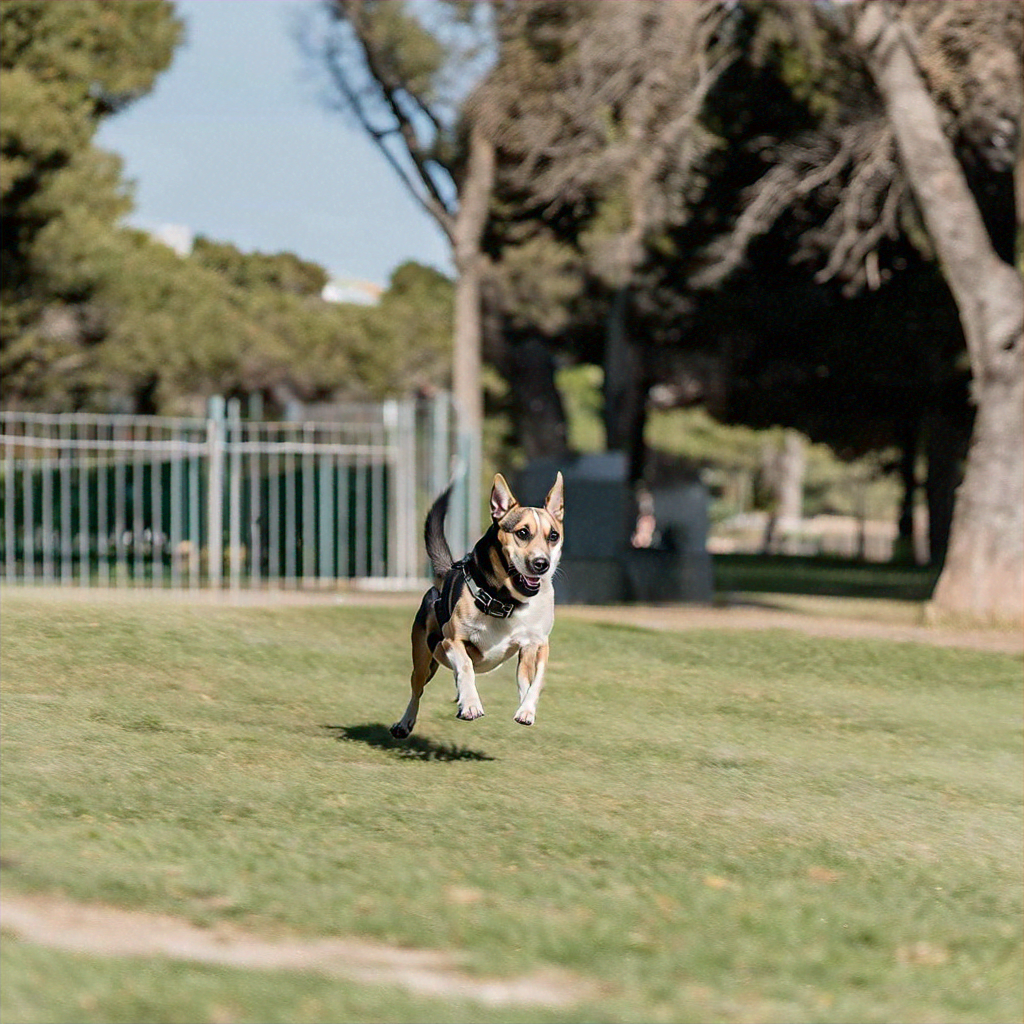

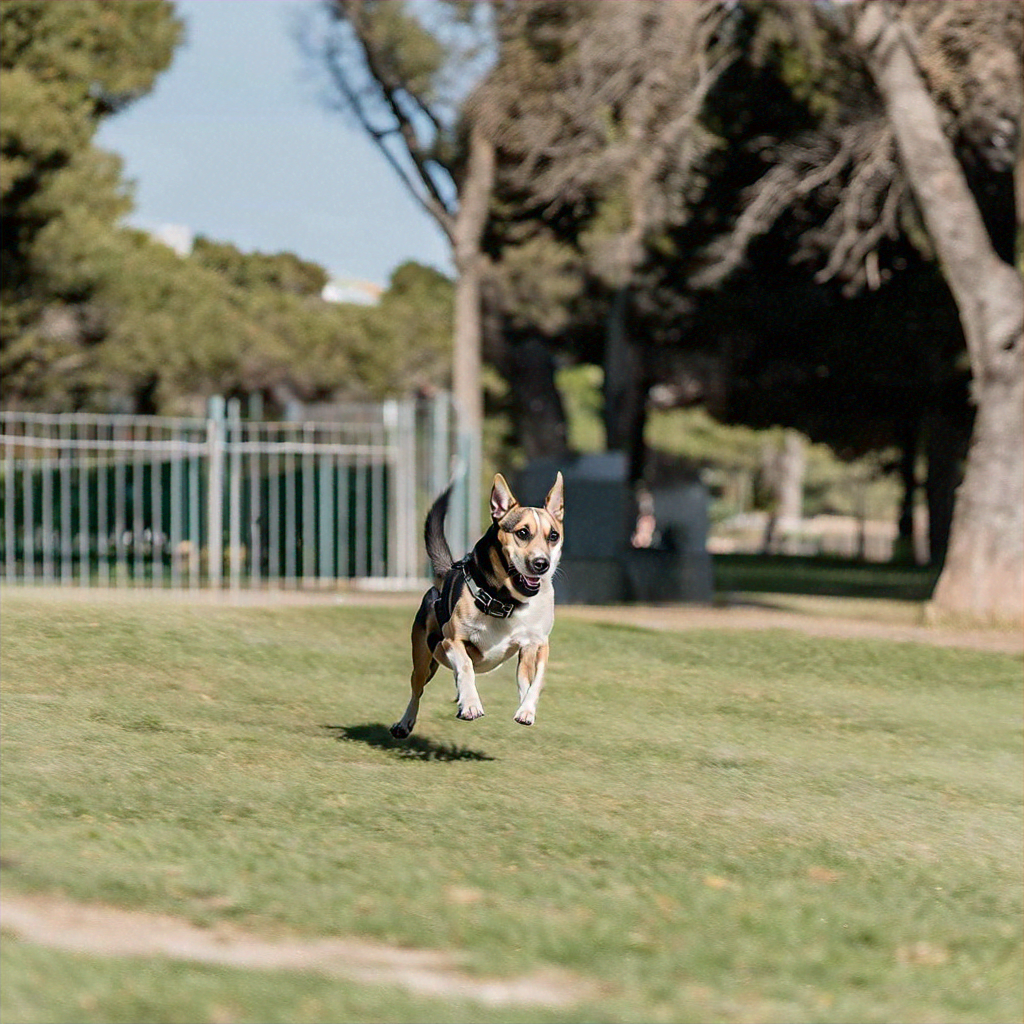

In [ ]:
import base64
import io
import json
from PIL import Image

output_key = f"{dir}/output/{job_id}/{file_name}.jsonl.out"
output_obj = bucket.Object(key=output_key).get()
binary_contents = output_obj.get("Body").read()

# contents = list()
for line in io.BytesIO(binary_contents):
    content = json.loads(line.decode("utf-8"))
    # finish_reason = content.get("error")
    # if finish_reason is not None: print(f"Image generation error. Error is {finish_reason}")
    # contents.append(content)
    base64_image = content.get("modelOutput").get("images")[0]
    base64_bytes = base64_image.encode('ascii')
    image_bytes = base64.b64decode(base64_bytes)
    image = Image.open(io.BytesIO(image_bytes))
    image.show()